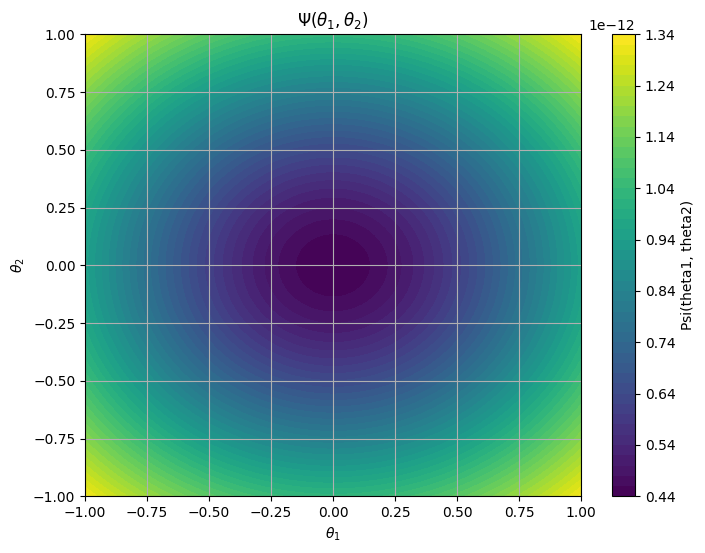

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants (replace these with actual values as needed)
D_ds = 1.0  # D_ds/D_s (dimensionless)
sigma_v = 1.0  # velocity dispersion
c = 3.0e5  # speed of light (km/s)
theta_c = 0.5  # core radius (dimensionless)
epsilon = 0.1  # ellipticity (dimensionless)

# Define the potential function
def psi(theta1, theta2):
    prefactor = (D_ds / 4.0 / np.pi) * (sigma_v**2 / c**2)
    term = theta_c**2 + (1 - epsilon) * theta1**2 + (1 + epsilon) * theta2**2
    return prefactor * np.sqrt(term)

# Create a grid of theta1 and theta2 values
theta1 = np.linspace(-1, 1, 100)  # Adjust range as needed
theta2 = np.linspace(-1, 1, 100)  # Adjust range as needed
theta1, theta2 = np.meshgrid(theta1, theta2)

# Calculate Psi for the grid
psi_values = psi(theta1, theta2)

# Plot the results
plt.figure(figsize=(8, 6))
contour = plt.contourf(theta1, theta2, psi_values, levels=50, cmap='viridis')
plt.colorbar(contour, label='Psi(theta1, theta2)')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title(r'$\Psi(\theta_1, \theta_2)$')
plt.grid(True)
plt.show()


Obtené las cáusticas y curvas crı́ticas (o sea, hacé gráficas de esas curvas) para las siguientes clases de modelos: 

elı́pticos

pseudo-elı́ptico

con cizallamiento externo. 

Podés elegir los perfiles radiales y los
parámetros de los modelos. Pueden obtener las soluciones buscando
las raı́ces de los auto-valores de la jacobiana de la transformación (en
el plano de las fuentes y en el plano de las lentes) o usando algún código
numerico público de lentes gravitacionales (como el gravlens).

In [103]:
from astropy.constants import c, G
import numpy as np
from scipy.optimize import brentq
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt

class sie_lens(object):
    """
    Class SIE
    """
    def __init__(self, co, zl=0.3, zs=2.0, sigmav=200, f=0.6, pa=45.0):
        """
        Initialize the SIE object.
        Dimensionless units are used. The scale angle is given by the
        SIS Einstein radius.
        """
        self.sigmav = sigmav  # velocity dispersion
        self.co = co  # cosmological model
        self.zl = zl  # lens redshift
        self.zs = zs  # source redshift
        self.f = f  # axis ratio
        self.pa = pa * np.pi / 180.0  # position angle
        # Compute the angular diameter distances:
        self.dl = self.co.angular_diameter_distance(self.zl)
        self.ds = self.co.angular_diameter_distance(self.zs)
        self.dls = self.co.angular_diameter_distance_z1z2(self.zl, self.zs)
        # Calculates the Einstein radius of the SIS lens in arcsec
        self.theta0 = np.rad2deg(
            (4.0 * np.pi * sigmav**2 / (c.to("km/s"))**2 *
             self.dls / self.ds).value) * 3600.0

    def delta(self, f, phi):
        return np.sqrt(np.cos(phi - self.pa)**2 + self.f**2 * np.sin(phi - self.pa)**2)

    def kappa(self, x, phi):
        """
        Convergence for the SIE lens at position (x, phi) in polar
        coordinates.
        """
        return np.sqrt(self.f) / 2.0 / x / self.delta(self.f, phi)

    def gamma(self, x, phi):
        """
        Shear for the SIE lens at position (x, phi) in polar coordinates.
        """
        return (
            -self.kappa(x, phi) * np.cos(2.0 * phi - self.pa),
            -self.kappa(x, phi) * np.sin(2.0 * phi - self.pa)
        )

    def mu(self, x, phi):
        """
        Magnification for the SIE lens at position (x, phi) in polar
        coordinates.
        """
        ga1, ga2 = self.gamma(x, phi)
        ga = np.sqrt(ga1 * ga1 + ga2 * ga2)
        return 1.0 / (1.0 - self.kappa(x, phi) - ga) / (1.0 - self.kappa(x, phi) + ga)

    def psi_tilde(self, phi):
        """
        Angular part of the lensing potential at the polar angle phi
        """
        if self.f < 1.0:
            fp = np.sqrt(1.0 - self.f**2)
            return np.sqrt(self.f) / fp * (
                np.sin(phi - self.pa) * np.arcsin(fp * np.sin(phi - self.pa)) +
                np.cos(phi - self.pa) * np.arcsinh(fp / self.f * np.cos(phi - self.pa))
            )
        else:
            return 1.0

    def psi(self, x, phi):
        """
        Lensing potential at polar coordinates x, phi
        """
        return x * self.psi_tilde(phi)

    def alpha(self, phi):
        """
        Deflection angle as a function of the polar angle phi
        """
        fp = np.sqrt(1.0 - self.f**2)
        a1 = np.sqrt(self.f) / fp * np.arcsinh(fp / self.f * np.cos(phi))
        a2 = np.sqrt(self.f) / fp * np.arcsin(fp * np.sin(phi))
        return a1, a2

    def cut(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        """
        Coordinates of the points on the cut.
        """
        phi = np.linspace(phi_min, phi_max, nphi)
        y1_, y2_ = self.alpha(phi)
        y1 = y1_ * np.cos(self.pa) - y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return -y1, -y2

    def tan_caustic(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        """
        Coordinates of the points on the tangential caustic.
        """
        phi = np.linspace(phi_min, phi_max, nphi)
        delta = np.sqrt(np.cos(phi)**2 + self.f**2 * np.sin(phi)**2)
        a1, a2 = self.alpha(phi)
        y1_ = np.sqrt(self.f) / delta * np.cos(phi) - a1
        y2_ = np.sqrt(self.f) / delta * np.sin(phi) - a2
        y1 = y1_ * np.cos(self.pa) - y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return y1, y2

    def tan_cc(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        """
        Coordinates of the points on the tangential critical line.
        """
        phi = np.linspace(phi_min, phi_max, nphi)
        delta = np.sqrt(np.cos(phi)**2 + self.f**2 * np.sin(phi)**2)
        r = np.sqrt(self.f) / delta
        x1 = r * np.cos(phi + self.pa)
        x2 = r * np.sin(phi + self.pa)
        return x1, x2

    def x_ima(self, y1, y2, phi):
        """
        Distance of the image from the lens center
        """
        return y1 * np.cos(phi) + y2 * np.sin(phi) + self.psi_tilde(phi + self.pa)

    def phi_ima(self, y1, y2, checkplot=True, eps=0.001, nphi=100):
        """
        Solve the lens Equation for a given source position (y1, y2)
        """
        y1_ = y1 * np.cos(self.pa) + y2 * np.sin(self.pa)
        y2_ = -y1 * np.sin(self.pa) + y2 * np.cos(self.pa)

        def phi_func(phi):
            a1, a2 = self.alpha(phi)
            return (y1_ + a1) * np.sin(phi) - (y2_ + a2) * np.cos(phi)

        U = np.linspace(0., 2.0 * np.pi + eps, nphi)
        c = phi_func(U)
        s = np.sign(c)
        phi = []
        xphi = []

        for i in range(len(U) - 1):
            if s[i] + s[i + 1] == 0:
                u = brentq(phi_func, U[i], U[i + 1])
                z = phi_func(u)
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x = self.x_ima(y1_, y2_, u)
                if x > 0:
                    phi.append(u)
                    xphi.append(x)

        xphi = np.array(xphi)
        phi = np.array(phi)
        return xphi, phi + self.pa

# define a SIE lens with sigmav=200 km/s, f=0.3, pa=0.0
sigmav=200.0
f=0.3
pa=0.0
co = FlatLambdaCDM(Om0=0.3,H0=70.0)
sie=sie_lens(co,sigmav=sigmav,f=f,pa=pa)
# source coordinates
y1=0.2
y2=0.2
# set up a figure
# fig,ax=plt.subplots(1,2,figsize=(18,8))
# polar coordinates of the images
x,phi=sie.phi_ima(y1,y2)
# convert to Cartesian coordinates
x1_ima=x*np.cos(phi)
x2_ima=x*np.sin(phi)
# compute cut, caustic, and critical line
y1_cut,y2_cut=sie.cut()
y1_cau,y2_cau=sie.tan_caustic()
x1_cc,x2_cc=sie.tan_cc()

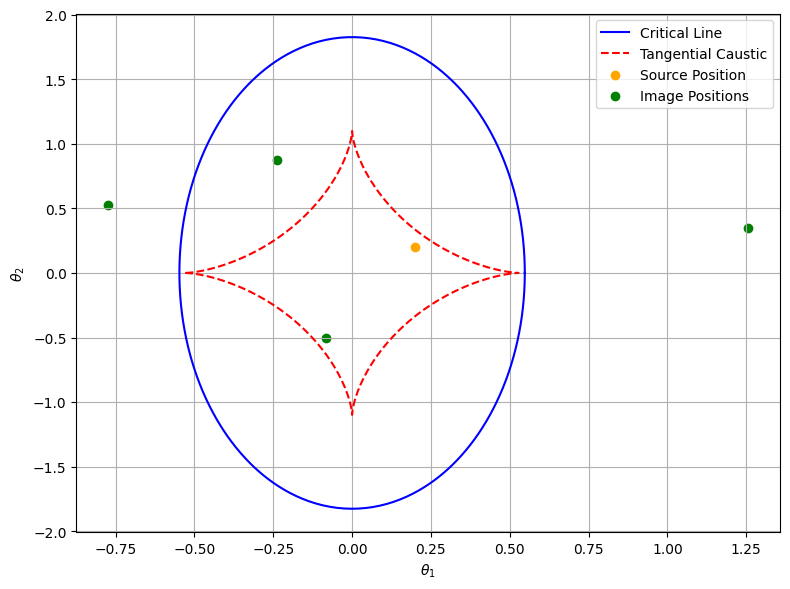

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Define the functions for the left panel
phi = np.linspace(0, 2 * np.pi, 1000)

# Function F(phi): Lens equation function
def F_phi(phi, y1, y2):
    def phi_func(phi):
        a1, a2 = sie.alpha(phi)
        return (y1 + a1) * np.sin(phi) - (y2 + a2) * np.cos(phi)
    return phi_func(phi)

# Compute F(phi) and identify zeros
F_vals = np.array([F_phi(p, y1, y2) for p in phi])
zeros_phi = [brentq(lambda p: F_phi(p, y1, y2), phi[i], phi[i+1])
             for i in range(len(phi) - 1) if F_vals[i] * F_vals[i+1] < 0]

# Compute x(phi): Distance of the image from the lens center
x_vals = np.array([sie.x_ima(y1, y2, p) for p in phi])

# Right Panel: Critical lines and caustics
y1_cut, y2_cut = sie.cut()
y1_cau, y2_cau = sie.tan_caustic()
x1_cc, x2_cc = sie.tan_cc()

# Create the plots
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Left panel: F(phi) and x(phi)
# ax[0].plot(phi, F_vals, label=r"$F(\phi)$", color="blue")
# ax[0].plot(phi, x_vals, label=r"$x(\phi)$", color="orange")
# ax[0].scatter(zeros_phi, [0] * len(zeros_phi), color="green", label="Zeros of $F(\phi)$")
# ax[0].set_xlabel(r"$\phi$")
# ax[0].set_ylabel(r"$F(\phi), x(\phi)$")
# ax[0].legend()
# ax[0].grid()

# Right panel: Lens plane
ax.plot(x1_cc, x2_cc, color="blue", label="Critical Line")
ax.plot(y1_cau, y2_cau, 'r--', label="Tangential Caustic")
# ax.scatter(0, 0, color="red", label="Lens Center")  # Lens center
ax.scatter(y1, y2, color="orange", label="Source Position")  # Source position
ax.scatter(
    [sie.x_ima(y1, y2, p) * np.cos(p) for p in zeros_phi],
    [sie.x_ima(y1, y2, p) * np.sin(p) for p in zeros_phi],
    color="green", label="Image Positions"
)
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.legend()
ax.grid()

# Display plots
plt.tight_layout()
plt.savefig('/home/anibal-pc/SIE_caustics.png')
plt.show()



In [108]:
import numpy.fft as fftengine
import numpy as np
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt

class gen_lens(object):
    """
    Initialize gen_lens
    """
    # The lens does not have a potential yet
    def __init__(self):
        self.pot_exists = False

    # Convergence
    def convergence(self):
        if self.pot_exists:
            kappa = 0.5 * (self.a11 + self.a22)
        else:
            print("The lens potential is not initialized yet")
            return None
        return kappa

    # Shear
    def shear(self):
        if self.pot_exists:
            g1 = 0.5 * (self.a11 - self.a22)
            g2 = self.a12
        else:
            print("The lens potential is not initialized yet")
            return None, None
        return g1, g2

    # Determinant of the Jacobian matrix
    def detA(self):
        if self.pot_exists:
            deta = (1.0 - self.a11) * (1.0 - self.a22) - self.a12 * self.a21
        else:
            print("The lens potential is not initialized yet")
            return None
        return deta

    # # Critical lines overlaid to the map of detA
    def crit_lines(self, ax=None, show=True):
        if ax is None:
            print("Specify the axes to display the critical lines")
        else:
            deta = self.detA()
            cs = ax.contour(deta, levels=[0.0], colors='white', alpha=0.0)
            if not show:
                ax.clear()
            return cs

    def clines(self, ax=None, color='red', alpha=1.0, lt='-'):
        cs = self.crit_lines(ax=ax, show=False)
        try:
            # Preferred for older Matplotlib versions
            contour = cs.collections[0]
            paths = contour.get_paths()
        except AttributeError:
            # Preferred for Matplotlib 3.8 and beyond
            paths = cs.get_paths()
    
        sizevs = np.empty(len(paths), dtype=int)
        no = self.pixel
    
        # If we found any contour, then we proceed
        if sizevs.size > 0:
            for j in range(len(paths)):
                # For each path, we create two vectors containing
                # the x1 and x2 coordinates of the vertices
                vs = paths[j].vertices
                sizevs[j] = len(vs)
                x1, x2 = [], []
                for i in range(len(vs)):
                    xx1, xx2 = vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                # Plot the results
                ax.plot((np.array(x1) - self.npix / 2.0) * no,
                        (np.array(x2) - self.npix / 2.0) * no,
                        lt, color=color, alpha=alpha)


    # # Plot of the caustics in the axes ax
    def caustics(self, ax=None, alpha=1.0, color='red', lt='-'):
        cs = self.crit_lines(ax=ax, show=True)
        contour = cs.collections[0]
        paths = contour.get_paths()  # Contains the paths of each individual critical line
        sizevs = np.empty(len(paths), dtype=int)

        # If we found any contour, then we proceed
        if sizevs.size > 0:
            for j in range(len(paths)):
                # For each path, we create two vectors containing
                # the x1 and x2 coordinates of the vertices
                vs = paths[j].vertices
                sizevs[j] = len(vs)
                x1, x2 = [], []
                for i in range(len(vs)):
                    xx1, xx2 = vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                a_1 = map_coordinates(self.a1, [[x2], [x1]], order=1)
                a_2 = map_coordinates(self.a2, [[x2], [x1]], order=1)
                
                # Mapping using the lens equation
                no = self.pixel
                y1 = (x1 - a_1[0] - self.npix / 2.0) * no
                y2 = (x2 - a_2[0] - self.npix / 2.0) * no
                
                # Plot the results
                ax.plot(y1, y2, lt, color=color, alpha=alpha)

    # Geometrical time delay
    def t_geom_surf(self, beta=None):
        x = np.arange(0, self.npix, 1, float) * self.pixel
        y = x[:, np.newaxis]
        if beta is None:
            x0 = y0 = self.npix / 2 * self.pixel
        else:
            x0 = beta[0] + self.npix / 2 * self.pixel
            y0 = beta[1] + self.npix / 2 * self.pixel
        return 0.5 * ((x - x0) * (x - x0) + (y - y0) * (y - y0))

    # Gravitational time delay
    def t_grav_surf(self):
        return -self.pot

    # Total time delay
    def t_delay_surf(self, beta=None):
        t_grav = self.t_grav_surf()
        t_geom = self.t_geom_surf(beta)
        return t_grav + t_geom

    # Display the time delay contours
    def show_contours(self, surf0, ax=None, minx=-25, miny=-25,
                      cmap=plt.get_cmap('Paired'), linewidth=1, fontsize=20,
                      nlevels=40, levmax=100, offz=0.0):
        if ax is None:
            print("Specify the axes to display the contours")
        else:
            minx, maxx = minx, -minx
            miny, maxy = miny, -miny
            surf = surf0 - np.min(surf0)
            levels = np.linspace(np.min(surf), levmax, nlevels)
            ax.contour(surf, cmap=cmap, levels=levels, linewidth=linewidth,
                       extent=[-self.size / 2, self.size / 2, -self.size / 2, self.size / 2])
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            ax.set_xlabel(r'$\theta_1$', fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$', fontsize=fontsize)
            ax.set_aspect('equal')


/tmp/ipykernel_2852030/1153663826.py:87: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour = cs.collections[0]
/tmp/ipykernel_2852030/1153663826.py:57: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour = cs.collections[0]


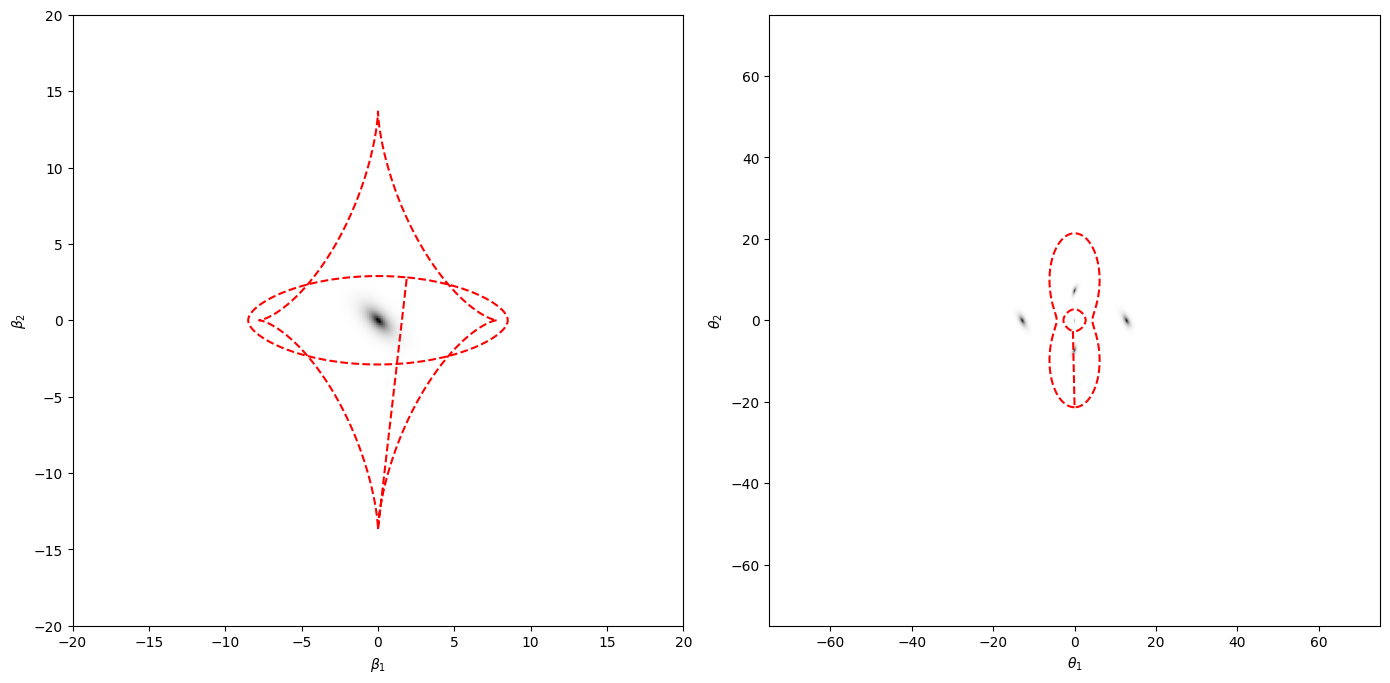

In [109]:
class PSIEc(gen_lens):
    def __init__(self, co, size=100.0, npix=200, **kwargs):
        # Set the cosmological model
        self.co = co
        
        # Core radius
        if 'theta_c' in kwargs:
            self.theta_c = kwargs['theta_c']
        else:
            self.theta_c = 0.0
        
        # Ellipticity
        if 'ell' in kwargs:
            self.ell = kwargs['ell']
        else:
            self.ell = 0.0
        
        # Normalization
        if 'norm' in kwargs:
            self.norm = kwargs['norm']
        else:
            self.norm = 1.0
        
        # Lens redshift
        if 'zl' in kwargs:
            self.zl = kwargs['zl']
        else:
            self.zl = 0.5
        
        # Source redshift
        if 'zs' in kwargs:
            self.zs = kwargs['zs']
        else:
            self.zs = 1.0
        
        # Angular diameter distances
        self.dl = co.angular_diameter_distance(self.zl)
        self.ds = co.angular_diameter_distance(self.zs)
        self.dls = co.angular_diameter_distance_z1z2(self.zl, self.zs)
        
        # Size of the output image
        self.size = size
        
        # Number of pixels
        self.npix = npix
        
        # Pixel scale
        self.pixel = self.size / self.npix
        
        # Calculate the lensing potential
        self.potential()
    
    # Lensing potential and its derivatives
    def potential(self):
        x = np.arange(0, self.npix, 1, float)
        y = x[:, np.newaxis]
        x0 = y0 = self.npix / 2
        self.pot_exists = True
        
        self.pot = np.sqrt(
            ((x - x0) * self.pixel) ** 2 / (1 - self.ell) +
            ((y - y0) * self.pixel) ** 2 * (1 - self.ell) +
            self.theta_c ** 2
        ) * self.norm
        
        self.a2, self.a1 = np.gradient(self.pot / self.pixel ** 2)
        self.a12, self.a11 = np.gradient(self.a1)
        self.a22, self.a21 = np.gradient(self.a2)


class sersic(object):
    def __init__(self, size, N, gl=None, **kwargs):
        if 'n' in kwargs:
            self.n = kwargs['n']
        else:
            self.n = 4
        
        if 're' in kwargs:
            self.re = kwargs['re']
        else:
            self.re = 5.0
        
        if 'q' in kwargs:
            self.q = kwargs['q']
        else:
            self.q = 1.0
        
        if 'pa' in kwargs:
            self.pa = kwargs['pa']
        else:
            self.pa = 0.0
        
        if 'ys1' in kwargs:
            self.ys1 = kwargs['ys1']
        else:
            self.ys1 = 0.0
        
        if 'ys2' in kwargs:
            self.ys2 = kwargs['ys2']
        else:
            self.ys2 = 0.0
        
        if 'zs' in kwargs:
            self.zs = kwargs['zs']
        else:
            self.zs = 1.0
        
        self.N = N
        self.size = float(size)
        self.df = gl
        
        # Define the pixel coordinates
        pc = np.linspace(-self.size / 2.0, self.size / 2.0, self.N)
        self.x1, self.x2 = np.meshgrid(pc, pc)
        
        if self.df is not None:
            ds_lens = gl.ds
            dls_lens = gl.dls
            ds = gl.co.angular_diameter_distance(self.zs)
            dls = gl.co.angular_diameter_distance_z1z2(gl.zl, self.zs)
            self.corrf = ds_lens / dls_lens * dls / ds
            
            if self.zs != gl.zs:
                gl.rescale(self.corrf)
            
            y1, y2 = self.ray_trace()
        else:
            y1, y2 = self.x1, self.x2
        
        self.image = self.brightness(y1, y2)
    
    def rescale(self, fcorr):
        if self.pot_exists:
            self.pot *= fcorr
            self.a1 *= fcorr
            self.a2 *= fcorr
            self.a12 *= fcorr
            self.a11 *= fcorr
            self.a22 *= fcorr
            self.a21 *= fcorr
    
    def ray_trace(self):
        """
        Ray-tracing through the lens plane
        """
        px = self.df.pixel
        x1pix = (self.x1 + self.df.size / 2.0) / px
        x2pix = (self.x2 + self.df.size / 2.0) / px
        
        # Compute the deflection angles at the light ray positions
        a1 = map_coordinates(self.df.a1, [x2pix, x1pix], order=2) * px
        a2 = map_coordinates(self.df.a2, [x2pix, x1pix], order=2) * px
        
        # Apply the lens equation
        y1 = self.x1 - a1  # y1 coordinates on the source plane
        y2 = self.x2 - a2  # y2 coordinates on the source plane
        
        return y1, y2
    
    def brightness(self, y1, y2):
        # Rotate the galaxy by the angle self.pa
        x = np.cos(self.pa) * (y1 - self.ys1) + np.sin(self.pa) * (y2 - self.ys2)
        y = -np.sin(self.pa) * (y1 - self.ys1) + np.cos(self.pa) * (y2 - self.ys2)
        
        # Include elliptical isophotes
        r = np.sqrt((x / self.q) ** 2 + y ** 2)
        
        # Brightness at distance r
        bn = 1.992 * self.n - 0.3271
        brightness = np.exp(-bn * ((r / self.re) ** (1.0 / self.n) - 1.0))
        
        return brightness


# Set cosmological parameters
co = FlatLambdaCDM(H0=70, Om0=0.3)

# Lens parameters
kwargs = {
    'theta_c': 2.0,
    'norm': 10.0,
    'ell': 0.4,
    'zl': 0.5,
    'zs': 1.0
}

el = PSIEc(co, size=80, npix=1000, **kwargs)

# Size of the source image
size_stamp = 150.0
npix_stamp = 1000
xmin, xmax = -el.size / 2, el.size / 2
ymin, ymax = -el.size / 2, el.size / 2

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Sersic source with no lensing
beta = [0, 0]
kwargs = {
    'q': 0.5,
    're': 1.0,
    'pa': np.pi / 4.0,
    'n': 1,
    'ys1': beta[0],
    'ys2': beta[1],
    'zs': 1.0
}
se_unlensed = sersic(size_stamp, npix_stamp, **kwargs)

# Sersic source with lensing
se = sersic(size_stamp, npix_stamp, gl=el, **kwargs)

# Compute the time delay surface for a source at beta
td = el.t_delay_surf(beta=beta)

# Draw caustics (on the left) and critical lines (on the right)
el.caustics(ax=ax[0], lt='--', alpha=1.0)
el.clines(ax=ax[1], lt='--', alpha=1.0)

# Show unlensed (on the left) and lensed (on the right) images
ax[0].imshow(se_unlensed.image, origin='lower',
             extent=[-se.size / 2, se.size / 2, -se.size / 2, se.size / 2],
             cmap='gray_r')
ax[1].imshow(se.image, origin='lower',
             extent=[-se.size / 2, se.size / 2, -se.size / 2, se.size / 2],
             cmap='gray_r')

# Show contours of the time delay surface
# el.show_contours(td, ax=ax[1], minx=xmin, miny=ymin, nlevels=35, levmax=500, fontsize=20)

x0, x1 = -20, 20
y0, y1 = -20, 20
ax[0].set_xlim([x0, x1])
ax[0].set_ylim([y0, y1])
ax[0].set_ylabel(r'$\beta_2$')
ax[0].set_xlabel(r'$\beta_1$')
ax[1].set_ylabel(r'$\theta_2$')
ax[1].set_xlabel(r'$\theta_1$')

fig.tight_layout()
plt.savefig('/home/anibal-pc/psei.png')

In [1]:
# kappa_SIS